In [1]:
import sys
sys.path.append("../")
import re
from os.path import join
from IPython.display import display

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('text', usetex=True)

import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
import numpy as np
import torch
import torch.utils.data as data_utils
from sklearn.neighbors import NearestNeighbors
import joblib
from tqdm import tqdm

from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from params import *
from utils import params_to_dataframe

fontsize=24

In [2]:
auto_var.summary()

{   'attack': {   'argument_fn': {   'multitarget': <function AttackVarClass.multitarget at 0x1475e8700>,
                                     'pgd': <function AttackVarClass.pgd at 0x1475e8670>},
                  'cache_dirs': {'multitarget': None, 'pgd': None},
                  'default': None,
                  'required_vars': {'multitarget': None, 'pgd': None},
                  'type': 'choice'},
    'dataset': {   'argument_fn': {   'cifar10': <function DatasetVarClass.cifar10 at 0x1475e83a0>,
                                      'fashion_mnist': <function DatasetVarClass.fashion_mnist at 0x1475e8550>,
                                      'mnist': <function DatasetVarClass.mnist at 0x1475e8310>,
                                      'resImgnet112v3': <function DatasetVarClass.resImgnet112v3 at 0x1475e84c0>,
                                      'svhn': <function DatasetVarClass.svhn at 0x1475e8430>},
                   'cache_dirs': {   'cifar10': None,
                     

In [3]:
print(auto_var.var_shown_name)

{'norm': {'inf': 'inf', '2': 'l2', '1': 'l1'}, 'dataset': {'mnist': 'mnist', 'cifar10': 'Cifar10', 'svhn': 'SVHN', 'resImgnet112v3': 'Restricted ImageNet', 'fashion_mnist': 'fashion mnist'}, 'model': {'(?P<dataaug>[a-zA-Z0-9]+-)?(?P<loss>[a-zA-Z0-9\\.]+)-tor-(?P<arch>[a-zA-Z0-9_]+)(?P<hyper>-[a-zA-Z0-9\\.]+)?': 'torch_model'}, 'attack': {'pgd': 'pgd', 'multitarget': 'multitarget'}}


In [4]:
def get_nearest_oppo_dist(X, y, tstX, tsty, norm, n_jobs=10):
    if len(X.shape) > 2:
        X = X.reshape(len(X), -1)
        tstX = tstX.reshape(len(tstX), -1)
    p = norm

    def helper(yi):
        return NearestNeighbors(n_neighbors=1,
                metric='minkowski', p=p, n_jobs=12).fit(X[y != yi])
    nns = Parallel(n_jobs=n_jobs)(delayed(helper)(yi) for yi in np.unique(y))
    ret = np.zeros(len(X))
    tst_ret = np.zeros(len(tstX))
    for yi in np.unique(y):
        dist, _ = nns[yi].kneighbors(X[y==yi], n_neighbors=1)
        ret[np.where(y==yi)[0]] = dist[:, 0]
        
        dist, _ = nns[yi].kneighbors(tstX[tsty==yi], n_neighbors=1)
        tst_ret[np.where(tsty==yi)[0]] = dist[:, 0]

    return nns, ret, tst_ret

In [5]:
auto_var.set_variable_value("random_seed", 0)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", "fashion_mnist")
nns_linf, fashion_mnist_dists_linf, tst_fashion_mnist_dists_linf = get_nearest_oppo_dist(trnX, trny, tstX, tsty, np.inf, n_jobs=1)
#data = {
#    "nns_linf": nns_linf,
#    "dists_linf": mnist_dists_linf,
#    "tst_dists_linf": tst_mnist_dists_linf,
#}
#joblib.dump(data, "./dist_data/mnist_data.pkl")

4431872/4422102 [==============================] - 1s 0us/step


In [6]:
print(fashion_mnist_dists_linf.min(), fashion_mnist_dists_linf.mean())
print(tst_fashion_mnist_dists_linf.min(), tst_fashion_mnist_dists_linf.mean())

0.3176470696926117 0.657183476793766
0.3215686082839966 0.6564047184854745


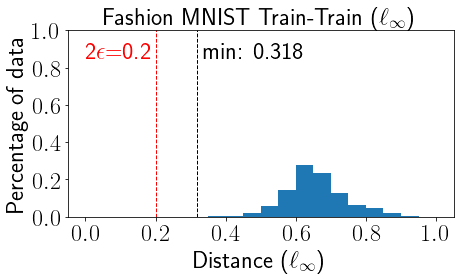

In [25]:
plt.figure(figsize=(6.5, 4))
plt.title("Fashion MNIST Train-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = fashion_mnist_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))
plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.018, 0.85, 'min: {:.3f}'.format(data.min()), fontsize=fontsize)
r = 0.1
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.2, 0.85, '2$\epsilon$={:.1f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("../figs/dataset_dist/fashion_mnist_linf_hist.png", format="png")
plt.savefig("../figs/dataset_dist/fashion_mnist_linf_hist.pdf", format="pdf")

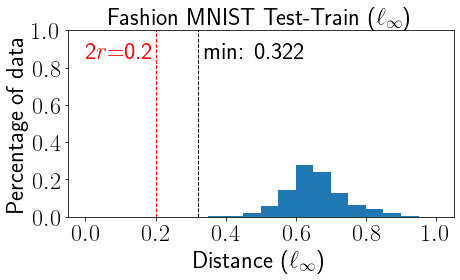

In [26]:
plt.figure(figsize=(6.5, 4))
plt.title("Fashion MNIST Test-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
data = tst_fashion_mnist_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))
plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.018, 0.85, 'min: {:.3f}'.format(data.min()), fontsize=fontsize)
r = 0.1
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.2, 0.85, '2$r$={:.1f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)


plt.tight_layout()
plt.savefig("../figs/dataset_dist/fashion_mnist_test_linf_hist.png", format="png")
plt.savefig("../figs/dataset_dist/fashion_mnist_test_linf_hist.pdf", format="pdf")

In [11]:
auto_var.set_variable_value("random_seed", 0)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", "mnist")
nns_linf, mnist_dists_linf, tst_mnist_dists_linf = get_nearest_oppo_dist(trnX, trny, tstX, tsty, np.inf, n_jobs=1)
#data = {
#    "nns_linf": nns_linf,
#    "dists_linf": mnist_dists_linf,
#    "tst_dists_linf": tst_mnist_dists_linf,
#}
#joblib.dump(data, "./dist_data/mnist_data.pkl")

In [12]:
print(mnist_dists_linf.min(), mnist_dists_linf.mean())
print(tst_mnist_dists_linf.min(), tst_mnist_dists_linf.mean())

0.7372549176216125 0.9895588241517543
0.8117647171020508 0.9896345104217529


FileNotFoundError: [Errno 2] No such file or directory: './figs/dataset_dist/mnist_linf_hist.png'

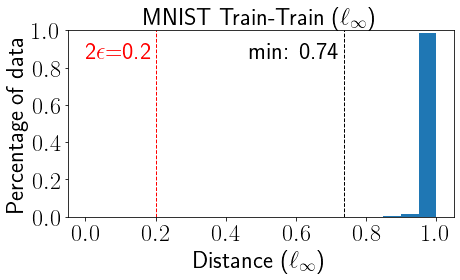

In [13]:
plt.figure(figsize=(6.5, 4))
plt.title("MNIST Train-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = mnist_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))
plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()-0.27, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.1
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.2, 0.85, '2$\epsilon$={:.1f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("./figs/dataset_dist/mnist_linf_hist.png", format="png")
plt.savefig("./figs/dataset_dist/mnist_linf_hist.pdf", format="pdf")

FileNotFoundError: [Errno 2] No such file or directory: './figs/dataset_dist/mnist_test_linf_hist.png'

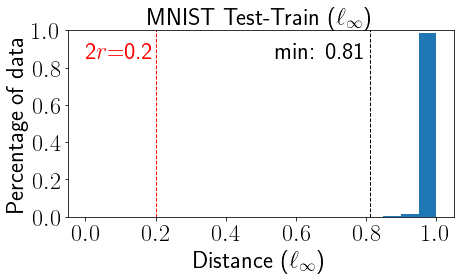

In [14]:
plt.figure(figsize=(6.5, 4))
plt.title("MNIST Test-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
data = tst_mnist_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))
plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()-0.27, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.1
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.2, 0.85, '2$r$={:.1f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)


plt.tight_layout()
plt.savefig("./figs/dataset_dist/mnist_test_linf_hist.png", format="png")
plt.savefig("./figs/dataset_dist/mnist_test_linf_hist.pdf", format="pdf")

In [ ]:
auto_var.set_variable_value("random_seed", 0)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", "cifar10")
nns_linf, cifar10_dists_linf, tst_cifar10_dists_linf = get_nearest_oppo_dist(trnX, trny, tstX, tsty, np.inf, n_jobs=1)
#data = {
#    "nns_linf": nns_linf,
#    "dists_linf": cifar10_dists_linf,
#    "tst_dists_linf": tst_cifar10_dists_linf,
#}
#joblib.dump(data, "./dist_data/cifar10_data.pkl")

In [ ]:
print(cifar10_dists_linf.min(), cifar10_dists_linf.mean())
print(tst_cifar10_dists_linf.min(), tst_cifar10_dists_linf.mean())

In [ ]:
plt.figure(figsize=(6.5, 4))
plt.title("CIFAR-10 Train-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = cifar10_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))

plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.02, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.031
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.11, 0.65, '2$\epsilon$={:.3f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)


plt.tight_layout()
plt.savefig("./figs/dataset_dist/cifar10_linf_hist.png", format="png")
plt.savefig("./figs/dataset_dist/cifar10_linf_hist.pdf", format="pdf")

In [ ]:
plt.figure(figsize=(6.5, 4))
plt.title("CIFAR-10 Test-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = tst_cifar10_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))

plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.02, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.031
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.11, 0.65, '2$\epsilon$={:.3f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("./figs/dataset_dist/cifar10_test_linf_hist.png", format="png")
plt.savefig("./figs/dataset_dist/cifar10_test_linf_hist.pdf", format="pdf")

In [ ]:
auto_var.set_variable_value("random_seed", 0)
trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", "svhn")
#np.testing.assert_array_equal(trnX[25235], trnX[25236])
#trnX = np.delete(trnX, 25235, axis=0) # image 25235 and 25236 are exactly the same
#trny = np.delete(trny, 25235, axis=0)
#trnX = np.delete(trnX, 65042, axis=0) # incorrectly labeled (image with idx 65043 and 11933 are same image but different label...)
#trny = np.delete(trny, 65042, axis=0)
nns_linf, svhn_dists_linf, tst_svhn_dists_linf = get_nearest_oppo_dist(trnX, trny, tstX, tsty, np.inf, n_jobs=1)

In [ ]:
temp_svhn_dists_linf = svhn_dists_linf[svhn_dists_linf >= np.partition(svhn_dists_linf, 5)[:5].max()]
print(temp_svhn_dists_linf.min(), temp_svhn_dists_linf.mean())
print(tst_svhn_dists_linf.min(), tst_svhn_dists_linf.mean())

In [ ]:
np.partition(svhn_dists_linf, 5)[:5].max()

In [ ]:
plt.figure(figsize=(6.5, 4))
plt.title("SVHN Train-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
#plt.hist(svhn_dists_linf, range=(0, 1), weights=np.ones(len(svhn_dists_linf)) / len(svhn_dists_linf))
#plt.hist(tst_svhn_dists_linf, range=(0, 1), weights=np.ones(len(tst_svhn_dists_linf)) / len(tst_svhn_dists_linf))

data = svhn_dists_linf[svhn_dists_linf >= np.partition(svhn_dists_linf, 5)[:5].max()]
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))

plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.02, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.031
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.11, 0.65, '2$\epsilon$={:.3f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("./figs/dataset_dist/svhn_linf_hist.png", format="png")
plt.savefig("./figs/dataset_dist/svhn_linf_hist.pdf", format="pdf")

In [ ]:
plt.figure(figsize=(6.5, 4))
plt.title("SVHN Test-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = tst_svhn_dists_linf
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))

plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.02, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.031
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.11, 0.65, '2$\epsilon$={:.3f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("./figs/dataset_dist/svhn_test_linf_hist.png", format="png")
plt.savefig("./figs/dataset_dist/svhn_test_linf_hist.pdf", format="pdf")

In [ ]:
plt.imshow(trnX[11933])
print(trny[11933])
plt.savefig("svhn_11933.pdf", format="pdf")

In [ ]:
plt.imshow(trnX[65043])
print(trny[65043])
plt.savefig("svhn_11933_close(65043).pdf", format="pdf")

In [ ]:
plt.imshow(trnX[25235])
plt.savefig("svhn_25235.pdf", format="pdf")

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch
from sklearn.metrics import pairwise_distances
import numpy as np
import joblib
trn_ds = ImageFolder("../data/RestrictedImgNet/train",
    transform=transforms.Compose([
        transforms.Resize(72),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
    ]))
tst_ds = ImageFolder("../data/RestrictedImgNet/val",
    transform=transforms.Compose([
        transforms.Resize(72),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
    ]))

In [ ]:
tst_dists = joblib.load("../restricted_tst_linf.pkl")
np_tst_dist = tst_dists

In [ ]:
batch_size = 256
tst_loader = torch.utils.data.DataLoader(tst_ds, batch_size=batch_size, shuffle=False, num_workers=16)

for i, (xi, yi) in enumerate(tst_loader):
    yi = yi.numpy()
    end = min(len(tst_ds), (i+1)*batch_size)
    for j in range(i*batch_size, end):
        np_tst_dist[j, yi[j-i*batch_size]] = np.inf
print(np_tst_dist.min(), np_tst_dist.min(1).mean())

In [ ]:
plt.figure(figsize=(6.5, 4))
plt.title("Restricted ImageNet Test-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
#plt.hist(svhn_dists_linf, range=(0, 1), weights=np.ones(len(svhn_dists_linf)) / len(svhn_dists_linf))
#plt.hist(tst_svhn_dists_linf, range=(0, 1), weights=np.ones(len(tst_svhn_dists_linf)) / len(tst_svhn_dists_linf))

data = np_tst_dist.min(1)
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))

plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
plt.text(data.min()+0.02, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.005
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.06, 0.65, '2$\epsilon$={:.2f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("./figs/dataset_dist/resImgNet_test_linf_hist.pdf", format="pdf")
plt.savefig("./figs/dataset_dist/resImgNet_test_linf_hist.png", format="png")

In [ ]:
def plot_and_save_figure(ds, fig_ids, file_prefix="figs/dataset_dist/resImgNet_"):
    for i in fig_ids:
        print(f"id: {i}, label: {ds[i][1]}")
        plt.imshow(ds[i][0].numpy().transpose(1, 2, 0))
        plt.savefig(file_prefix + f"{i}.png")

In [ ]:
plot_and_save_figure(trn_ds, fig_ids=[27782, 28340, 31382, 51605, 89607, 93380], file_prefix="figs/dataset_dist/resImgNet_")

In [ ]:
print(trn_ds[51605][1])
plt.imshow(trn_ds[51605][0].numpy().transpose(1, 2, 0))
plt.savefig("figs/dataset_dist/resImgNet_51605.png")

In [ ]:
plt.imshow(trn_ds[28340][0].numpy().transpose(1, 2, 0))
plt.savefig("figs/dataset_dist/resImgNet_51605.png")

In [ ]:
dists = joblib.load("./dist_data/restricted_trn_linf.pkl")
np_dist = dists
batch_size = 256
loader = torch.utils.data.DataLoader(trn_ds, batch_size=batch_size, shuffle=False, num_workers=16)

for i, (xi, yi) in enumerate(loader):
    yi = yi.numpy()
    end = min(len(trn_ds), (i+1)*batch_size)
    for j in range(i*batch_size, end):
        np_dist[j, yi[j-i*batch_size]] = np.inf
        
np_dist = np_dist.min(1)
np_dist_f = np_dist[np_dist >= np.partition(np_dist, 6)[6]]
print(np_dist_f.min(), np_dist_f.mean())

In [ ]:
plt.figure(figsize=(6.5, 4))
plt.title("Restricted ImageNet Train-Train ($\ell_\infty$)", fontsize=fontsize)
plt.ylabel("Percentage of data", fontsize=fontsize)
plt.xlabel("Distance ($\ell_\infty$)", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

data = np_dist_f
plt.hist(data, range=(0, 1), bins=20, weights=np.ones(len(data)) / len(data))

plt.axvline(data.min(), color='k', linestyle='dashed', linewidth=1)
#plt.text(-0.0, 0.35, 'min: {:.2f}'.format(np.partition(np_dist.min(1), 6)[7]), fontsize=fontsize)
plt.text(data.min()+0.02, 0.85, 'min: {:.2f}'.format(data.min()), fontsize=fontsize)
r = 0.005
plt.axvline(2*r, color='r', linestyle='dashed', linewidth=1)
plt.text(2*r-0.06, 0.65, '2$\epsilonr$={:.2f}'.format(2*r), fontsize=fontsize, color='r')
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig("./figs/dataset_dist/resImgNet_linf_hist.pdf", format="pdf")
plt.savefig("./figs/dataset_dist/resImgNet_linf_hist.png", format="png")

In [ ]:
joblib.dump(tst_dists.numpy(), "./dist_data/restricted_tst_linf.pkl")

In [ ]:
n_classes = 9
trn_dists = torch.ones((len(trn_ds), n_classes)).float()
batch_size = 192
trn_loader = torch.utils.data.DataLoader(trn_ds, batch_size=batch_size, shuffle=False, num_workers=12)
tst_loader = torch.utils.data.DataLoader(trn_ds, batch_size=batch_size, shuffle=False, num_workers=12)

for x, y in tqdm(trn_loader):
    y = y.numpy()
    x = x.flatten(1).cuda()
    for i, (xi, yi) in enumerate(tst_loader):
        yi = yi.numpy()
        xi = xi.flatten(1).cuda()
        
        cov = torch.norm(x.repeat((len(xi), 1)) - xi.repeat_interleave(len(x), dim=0), p=np.inf, dim=1)
        cov = cov.view(len(xi), len(x)).cpu()
        
        #cov = pairwise_distances(xi, x, metric='minkowski', n_jobs=16, p=np.inf)
        for j in range(n_classes):
            ty = (y == j)
            if ty.sum() >= 1:
                min_dist = cov[:, ty].min(axis=1)[0]
                trn_dists[i*batch_size: (i+1)*batch_size, j] = np.minimum(
                    trn_dists[i*batch_size: (i+1)*batch_size, j],
                    min_dist
                )